# Data z tramvají DPO
### Zkoumání pro korelaci s realitou

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
from tconsumption import Consumption, G_TO_MS2
import matplotlib.pyplot as plt

In [2]:
def remove_leader(path: str):
    return path.split(".")[-1]

def convert_sig_unsig(number):
    if number < 32767:
        return number
    else:
        return number-65535

def tram_csv_parser(csv_path):
    # Load from csv
    df = pd.read_csv(csv_path, delimiter=";", skiprows=73, decimal=",")
    default_cols = list(df.columns)

    # Rename cols
    rename_dict = {}
    for col in df.columns:
        new_name = remove_leader(col)
        rename_dict[col] = new_name
    df.rename(columns=rename_dict, inplace=True)

    # New cols (calculated)
    # Time
    df.insert(2, "DateTime", pd.to_datetime(df["Date"] + ' ' + df["Time"], format="%d.%m.%Y %H:%M:%S:%f"))
    del df["Date"]
    del df["Time"]
    df["delta_T"] = df["DateTime"].diff(periods=-1).abs()

    # Trakcni menic 1
    df["tm_stejnoproud_trakce"] = df["AM_A_C1_14_IwTCU_ILF1"].apply(convert_sig_unsig)/10
    df["tm_stejnoproud_spotrebice"] = df["AM_A_C1_14_IwAUX_I_DClink"]*0.1
    df["tm_stridaproud_vystupu"] = df["AM_A_C1_14_IwAUX_I_rms"]*0.01
    df["tm_vstupni_napeti"] = df["AM_A_C1_14_IwTCU_UD1Voltage"]/10
    df["tm_tah_vyvijeny_motory"] = df["AM_B_C1_15_IwTCU_E_MC1"].apply(convert_sig_unsig)/100
    df["tm_rychlost_3_napravy"] = df["VrTCU_A_A1_Velocity"]/3.6
    df["tm_prikon_trakce"] = df["tm_stejnoproud_trakce"]*df["tm_vstupni_napeti"]/1000
    df["tm_vykon_trakce"] = df["tm_tah_vyvijeny_motory"]*df["tm_rychlost_3_napravy"]
    df["tm_prikon_spotrebice"] = df["AM_A_C1_14_IwTCU_P_AUX"]/100
    df["tm_prikon_topeni_klima"] = 1.73*400*df["tm_stridaproud_vystupu"]/1000
    df["tm_vykon_zmareny"] = np.where((df["tm_vykon_trakce"] > 0) & (df["tm_vykon_trakce"] < df["tm_prikon_trakce"]), df["tm_prikon_trakce"]-df["tm_vykon_trakce"], 0)

    # Trakcni menic 2
    df["tm2_stejnoproud_trakce"] = df["AM_B_C1_15_IwTCU_ILF1"].apply(convert_sig_unsig)/10
    df["tm2_vstupni_napeti"] = df["AM_B_C1_15_IwTCU_UD1Voltage"]/10
    df["tm2_tah_vyvijeny_motory"] = df["AM_B_C1_15_IwTCU_E_MC1"].apply(convert_sig_unsig)/100
    df["tm2_rychlost_5_napravy"] = df["VrTCU_B_A1_Velocity"]/3.6
    df["tm2_prikon_trakce"] = df["tm2_stejnoproud_trakce"]*df["tm2_vstupni_napeti"]/1000
    df["tm2_vykon_trakce"] = df["tm2_tah_vyvijeny_motory"]*df["tm2_rychlost_5_napravy"]
    df["tm2_vykon_zmareny"] = np.where((df["tm2_vykon_trakce"] > 0) & (df["tm2_vykon_trakce"] < df["tm2_prikon_trakce"]), df["tm2_prikon_trakce"]-df["tm2_vykon_trakce"], 0)

    # Cela tramvaj
    df["cela_vykon_spotrebovany"] = np.where(df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"] > 0, df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"], 0)
    df["cela_vykon_spotrebovany_bez_spotrebicu"] = np.where(df["tm_prikon_trakce"]+df["tm2_prikon_trakce"] > 0, df["tm_prikon_trakce"]+df["tm2_prikon_trakce"], 0)
    df["cela_vykon_rekuperovany"] = np.where(df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"] < 0, -(df["tm_prikon_trakce"]+df["tm_prikon_spotrebice"]+df["tm2_prikon_trakce"]), 0)
    df["cela_vykon_rekuperovany_bez_spotrebicu"] = np.where(df["tm_prikon_trakce"]+df["tm2_prikon_trakce"] < 0, -(df["tm_prikon_trakce"]+df["tm2_prikon_trakce"]), 0)
    df["cela_vykon_zmareny"] = df["tm_vykon_zmareny"]+df["tm2_vykon_zmareny"]
    df["cela_vykon_trakce"] = df["tm_vykon_trakce"]+df["tm2_vykon_trakce"]
    df["cela_prikon_topeni_klima"] = df["tm_prikon_topeni_klima"]

    df["cela_energie_spotrebovana"] = (df["cela_vykon_spotrebovany"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_spotrebovana"] = 0.0

    df["cela_energie_spotrebovana_bez_spotrebicu"] = (df["cela_vykon_spotrebovany_bez_spotrebicu"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_spotrebovana_bez_spotrebicu"] = 0.0

    df["cela_energie_rekuperovana"] = (df["cela_vykon_rekuperovany"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_rekuperovana"] = 0.0

    df["cela_energie_rekuperovana_bez_spotrebicu"] = (df["cela_vykon_rekuperovany_bez_spotrebicu"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_rekuperovana_bez_spotrebicu"] = 0.0

    df["cela_energie_zmarena"] = (df["cela_vykon_zmareny"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_zmarena"] = 0.0

    df["cela_energie_topeni_klima"] = (df["cela_prikon_topeni_klima"]*df["delta_T"].dt.total_seconds()/3600).cumsum().shift(1)
    df.loc[0, "cela_energie_topeni_klima"] = 0.0

    df["km_total"] = df["QdwMesitTotalDistance"]*0.1

    return df
    return default_cols

"""
{
    "TYPE": "LineString",
    "coordinates": [
        [100.0, 0.0],
        [101.0, 1.0]
    ]
}
"""
def make_geojson(lat, long):
    geojson = {
        "type": "LineString",
    }
    geojson["coordinates"] = list(zip(long, lat))
    return json.dumps(geojson)

In [3]:
df = tram_csv_parser("../testing-data/DPO/Jízda_Poruba_Zátiší_20.04.2022/02-Vresinska-Zatisi_2022-04-20.csv")
[x for x in df.columns if "rychlost" in x.lower()]

['tm_rychlost_3_napravy', 'tm2_rychlost_5_napravy']

In [4]:
df_important = df[[
    "DateTime", "delta_T", "VrGpsLatitude", "VrGpsLongitude",
    "km_total", "tm_rychlost_3_napravy", "tm2_rychlost_5_napravy",
    "cela_vykon_spotrebovany_bez_spotrebicu", "cela_vykon_rekuperovany_bez_spotrebicu",
    "cela_energie_spotrebovana_bez_spotrebicu", "cela_energie_rekuperovana_bez_spotrebicu"
]]

df_important["cela_vykon_vyrovnany_bez_spotrebicu"] = df_important["cela_vykon_spotrebovany_bez_spotrebicu"]-df_important["cela_vykon_rekuperovany_bez_spotrebicu"]
df_important["cela_energie_vyrovnana_bez_spotrebicu"] = df_important["cela_energie_spotrebovana_bez_spotrebicu"]-df_important["cela_energie_rekuperovana_bez_spotrebicu"]

geojson = make_geojson(df_important["VrGpsLatitude"],df_important["VrGpsLongitude"])
with open("/tmp/test.geojson", "w") as f:
    f.write(geojson)

/tmp/ipykernel_40565/3941359690.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important["cela_vykon_vyrovnany_bez_spotrebicu"] = df_important["cela_vykon_spotrebovany_bez_spotrebicu"]-df_important["cela_vykon_rekuperovany_bez_spotrebicu"]
/tmp/ipykernel_40565/3941359690.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_important["cela_energie_vyrovnana_bez_spotrebicu"] = df_important["cela_energie_spotrebovana_bez_spotrebicu"]-df_important["cela_energie_rekuperovana_bez_spotrebicu"]


<Axes: xlabel='km_total'>

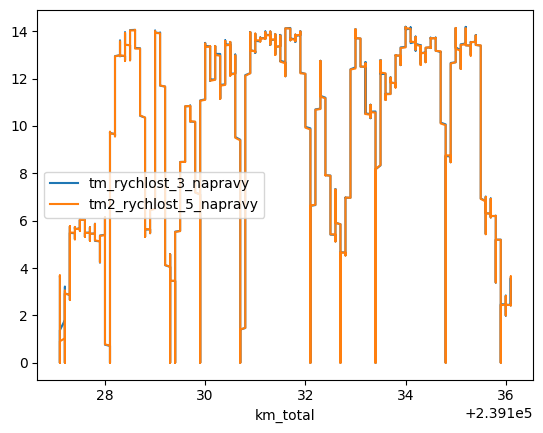

In [5]:
df_important.plot(x="km_total", y=["tm_rychlost_3_napravy", "tm2_rychlost_5_napravy"])

In [6]:
df_important.head()

,DateTime,delta_T,VrGpsLatitude,VrGpsLongitude,km_total,tm_rychlost_3_napravy,tm2_rychlost_5_napravy,cela_vykon_spotrebovany_bez_spotrebicu,cela_vykon_rekuperovany_bez_spotrebicu,cela_energie_spotrebovana_bez_spotrebicu,cela_energie_rekuperovana_bez_spotrebicu,cela_vykon_vyrovnany_bez_spotrebicu,cela_energie_vyrovnana_bez_spotrebicu
0,2022-04-20 09:07:04.479,0 days 00:00:00.098000,49.82271,18.15759,239127.1,3.627292,3.652425,57.07672,0.0,0.000000,0.0,57.07672,0.000000
1,2022-04-20 09:07:04.577,0 days 00:00:00.101000,49.82271,18.15759,239127.1,3.613089,3.660886,48.43046,0.0,0.001554,0.0,48.43046,0.001554
2,2022-04-20 09:07:04.678,0 days 00:00:00.100000,49.82271,18.15759,239127.1,3.590367,3.689089,31.35760,0.0,0.002912,0.0,31.35760,0.002912
3,2022-04-20 09:07:04.778,0 days 00:00:00.100000,49.82271,18.15759,239127.1,3.525036,3.672167,8.00986,0.0,0.003784,0.0,8.00986,0.003784
4,2022-04-20 09:07:04.878,0 days 00:00:00.100000,49.82271,18.15759,239127.1,3.507992,3.655244,4.67272,0.0,0.004006,0.0,4.67272,0.004006


12


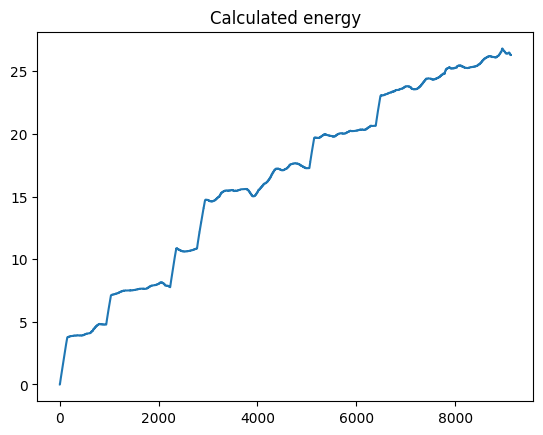

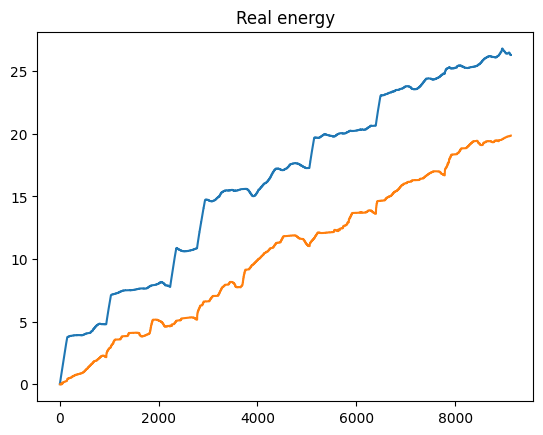

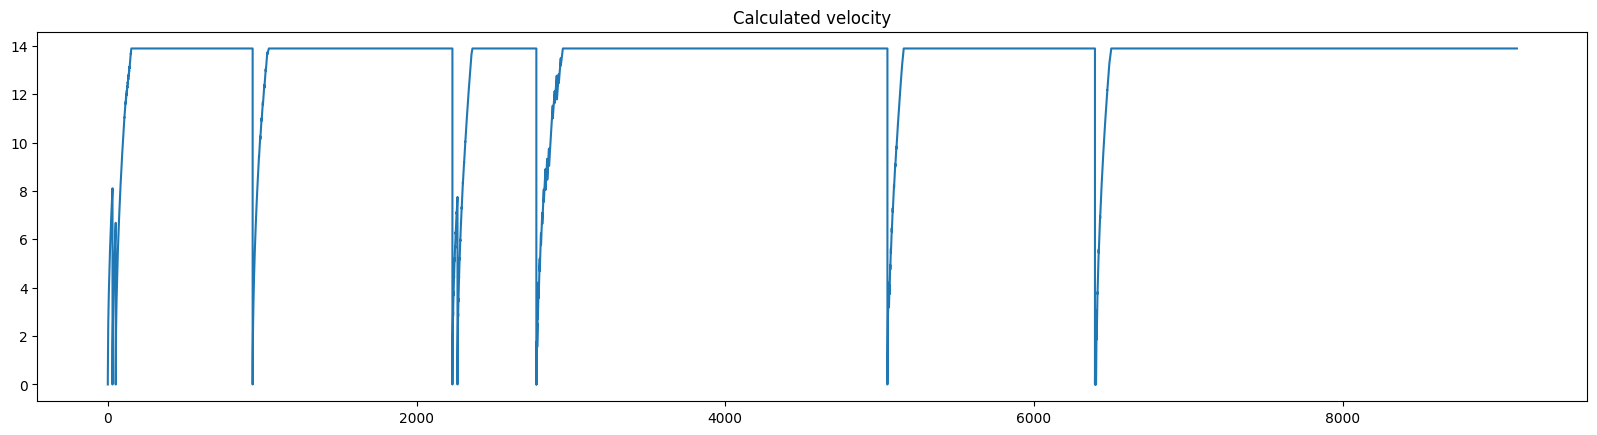

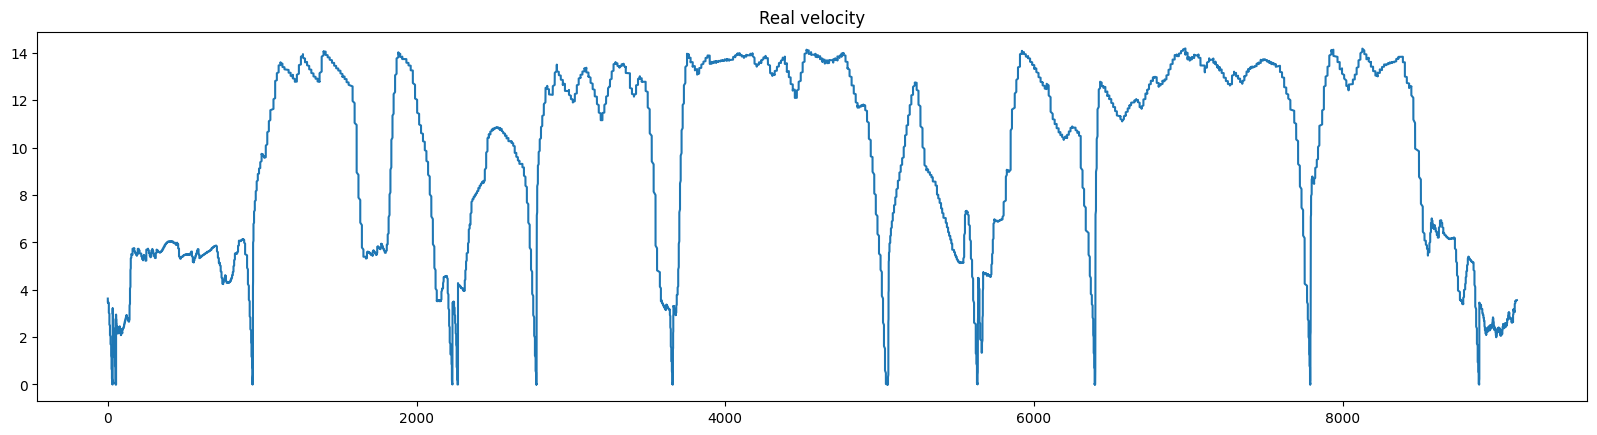

In [7]:
c = Consumption()
c.params["mass_locomotive"] = 34500
c.load_from_file("../testing-data/dpo-vresina-zatisi.geojson")

stations_stopped = []
last_row_zero = 0
for i,row in enumerate(df_important["tm_rychlost_3_napravy"]):
    if row == 0:
        if last_row_zero < i-1:
            stations_stopped.append(i)
        last_row_zero = i
c.stations = [c.stations[0]] + stations_stopped + [c.stations[-1]]
print(len(c.stations))
c.params["power_limit"] = df_important["cela_vykon_vyrovnany_bez_spotrebicu"].max()
c.params["acceleration_limit"] = 0.11*G_TO_MS2
c.run()

energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
plt.plot(c.series["dist_values"], energy_calculated)
plt.title("Calculated energy")
plt.show()

energy_real = df_important["cela_energie_vyrovnana_bez_spotrebicu"]
plt.plot(c.series["dist_values"], energy_calculated)
plt.plot(c.series["dist_values"], energy_real)
plt.title("Real energy")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(c.series["dist_values"], c.series["velocity_values"])
plt.title("Calculated velocity")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(c.series["dist_values"], list(df_important["tm_rychlost_3_napravy"]))
plt.title("Real velocity")
plt.show()

# df_important["tm_rychlost_3_napravy"].min()